# This Notebook Needs modular_alignments in the Same Directory

In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

from halotools.utils import crossmatch
from halotools.mock_observables import tpcf
from halotools.mock_observables.ia_correlations import ee_3d, ed_3d

import warnings
warnings.filterwarnings("ignore")

In [2]:
from modular_alignments.modular_alignment import align_to_halo, align_radially

# Variables

In [41]:
cen_mu = 0.802
sat_mu = 0.449
cen_mu = 0.6
sat_mu = 0.72
Lbox = Lbox = np.array( [ 110.7, 110.7, 110.7 ] )

In [4]:
rbins = np.logspace(-1,1.2,21)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

# Load Data

In [5]:
def associated_crossmatch(x, y1, y2):
    """
    Function for using crossmatch when a second value associated with the crossmatched y1 is desired.
    e.g. you have the tyipcal x, y (what we call y1) as defined in crossmatch where crossmatch is used as follows:
        Finds where the elements of ``x`` appear in the array ``y``, including repeats.

        The elements in x may be repeated, but the elements in y must be unique.
        The arrays x and y may be only partially overlapping.
    In addition to this step, there is a second y2 associated with y1 such that each y1 is associated to exactly one y2.
    This function is simply a convenient way to use the first crossmatch to access the proper entries of y2 associated with y1.
    
    y2 may be arbitrary dimensioned, so long as its first dimension equals the length of y2
    """
    inds1, inds2 = crossmatch(x,y)
    return y2[inds2]

def get_host_halo_pos(galaxy_id, group_id, galaxy_positions, central_mask):
    # By default (for centrals and any galaxies without a central for some reason), galaxy positions will be the host position
    host_halo_positions = np.array( galaxy_positions )
    
    central_id = galaxy_id[central_mask]
    central_group_id = group_id[central_mask]
    
    # Each central is the "head" of its group
    # Therefore, there is at most one central for each group (some weird groups may not have one?)
    # so if I crossmatch group_id -> central_group_id, central_group_id is lined up with central_id
    # already, so while central_group_id[inds2] simply reproduces the sorted list of group_id,
    # central_id[inds2] creates a list with the central_id associated with the group instead of the group itself
    
    inds1, inds2 = crossmatch(group_id, central_group_id)
    # Preserve original order (crossmatch sorts by default)
    order = np.argsort(inds1)
    # print(inds1)
    # inds1 = inds1[order]
    # inds2 = inds2[order]
    # print(inds1)
    
    associated_central_id = central_id[inds2]
    host_id = np.array(galaxy_id)
    host_id[inds1] = associated_central_id
    
    # Now that we have a list of the associated_central_id for each galaxy (the id of its central galaxy),
    # we can do a similar process to assign positions
    # if we crossmatch associated_central_id -> galaxy_id, while galaxy_id[inds2]
    # would give a list of the central_id, positions[inds2] will give a list of the central positions
    
    inds1, inds2 = crossmatch(associated_central_id, galaxy_id)
    # order = np.argsort(inds1)
    # print(inds1)
    # inds1 = inds1[order]
    # inds2 = inds2[order]
    # print(inds1)
    
    host_halo_positions[inds1] = galaxy_positions[inds2]
    
    return host_halo_positions
    

In [6]:
g_id = np.array( [0,1,2,3,4,5,6,7,8,9,10] )
gr_id = np.array( [0,0,0,2,1,2,3,3,3,4,4] )
g_pos = np.array( [ [0,0,0], [1,1,1], [2,2,2], [3,3,3], [4,4,4], [5,5,5], [6,6,6], [7,7,7], [8,8,8], [9,9,9], [10,10,10] ] )
mask = np.array( [1,0,0,1,1,0,1,0,0,1,0] ).astype(bool)
# mask = np.array( [1,0,0,1,1,0,1,0,0,1,0] ).astype(bool)

res = get_host_halo_pos(g_id, gr_id, g_pos, mask)

In [7]:
res

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [4, 4, 4],
       [3, 3, 3],
       [3, 3, 3],
       [6, 6, 6],
       [6, 6, 6],
       [6, 6, 6],
       [9, 9, 9],
       [9, 9, 9]])

In [8]:
import pickle
f_name = "TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl"
with open(f_name, 'rb') as file:
    data = pickle.load(file)

In [9]:
galaxy_coords = np.array( [ data["gal_pos_x"], data["gal_pos_y"], data["gal_pos_z"] ] ).T
galaxy_orientations = np.array( [ data["av_x"], data["av_y"], data["av_z"] ] ).T
halo_orientations = np.array( [ data["dm_av_x"], data["dm_av_y"], data["dm_av_z"] ] ).T
central_mask = data["central_bool"].astype(bool)

host_halo_positions = get_host_halo_pos( data["gal_id"], data["GroupID"], galaxy_coords, central_mask )

In [42]:
cen_major, cen_inter, cen_minor = align_to_halo(halo_orientations[central_mask][:,0], halo_orientations[central_mask][:,1], halo_orientations[central_mask][:,2],
                                 cen_mu)
sat_major, sat_inter, sat_minor = align_radially(host_halo_positions[~central_mask][:,0], host_halo_positions[~central_mask][:,1], host_halo_positions[~central_mask][:,2],
                                  galaxy_coords[~central_mask][:,0], galaxy_coords[~central_mask][:,1], galaxy_coords[~central_mask][:,2],
                                 Lbox, sat_mu)

galaxy_orientations[central_mask] = cen_major
galaxy_orientations[~central_mask] = sat_major

# Get Correlations

In [11]:
# Let's look at the halos themselves
halo_coords = np.array( [ data["gal_pos_x"], data["gal_pos_y"], data["gal_pos_z"] ] ).T
halo_orientation = np.array( [ data["dm_av_x"], data["dm_av_y"], data["dm_av_z"] ] ).T

halo_xi = tpcf(halo_coords, rbins, period = Lbox)
halo_omega = ed_3d(halo_coords, halo_orientation, halo_coords, rbins, period=Lbox)
halo_eta = ee_3d(halo_coords, halo_orientation, halo_coords, halo_orientation, rbins, period=Lbox)

In [12]:
# Get correlations from all the galaxies in data
data_coords_all = np.array( [ data["gal_pos_x"], data["gal_pos_y"], data["gal_pos_z"] ] ).T
data_orientations_all = np.array( [ data["av_x"], data["av_y"], data["av_z"] ] ).T
all_data_xi = tpcf(data_coords_all, rbins, period = Lbox)
all_data_omega = ed_3d(data_coords_all, data_orientations_all, data_coords_all, rbins, period=Lbox)
all_data_eta = ee_3d(data_coords_all, data_orientations_all, data_coords_all, data_orientations_all, rbins, period=Lbox)

In [43]:
# And finally from our alignment
xi = tpcf(galaxy_coords, rbins, period = Lbox)
omega = ed_3d(galaxy_coords, galaxy_orientations, galaxy_coords, rbins, period=Lbox)
eta = ee_3d(galaxy_coords, galaxy_orientations, galaxy_coords, galaxy_orientations, rbins, period=Lbox)

# Plots

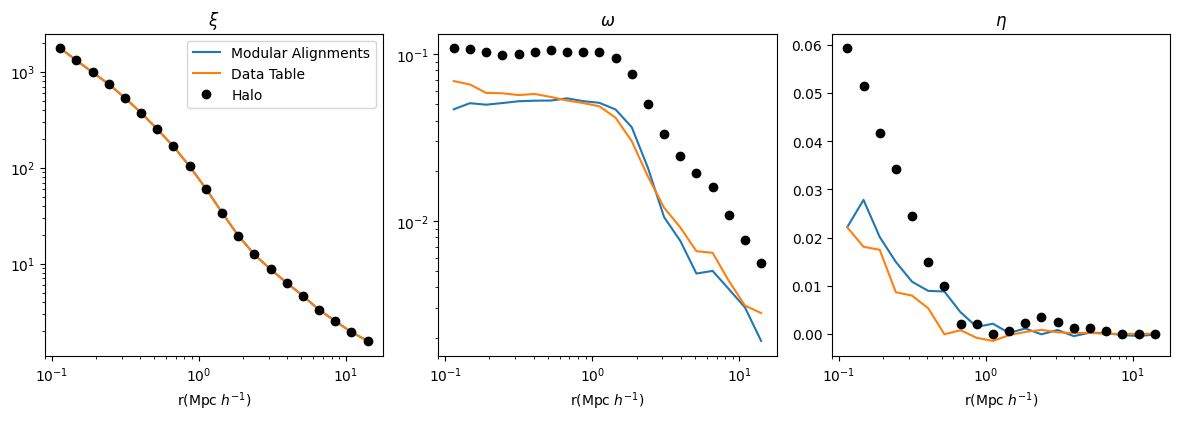

In [44]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

show_natural = True
show_absolute = False

axes[0].set_title(r'$\xi$')
axes[1].set_title(r'$\omega$')
axes[2].set_title(r'$\eta$')

if show_natural:
    axes[0].plot(rbin_centers, xi, label="Modular Alignments")
    axes[0].plot(rbin_centers, all_data_xi, label="Data Table")
    axes[0].plot(rbin_centers, halo_xi, "o", color="black", label="Halo") 
    
    axes[1].plot(rbin_centers, omega)
    axes[1].plot(rbin_centers, all_data_omega)
    axes[1].plot(rbin_centers, halo_omega, "o", color="black")
    
    axes[2].plot(rbin_centers, eta)
    axes[2].plot(rbin_centers, all_data_eta)
    axes[2].plot(rbin_centers, halo_eta, "o", color="black")
    

if show_absolute:
    # Plot data in the first subplot
    axes[0].plot(rbin_centers, abs(halo_xi), ":x", label="Abs(Halo)")
    # Plot data in the second subplot
    axes[1].plot(rbin_centers, abs(halo_omega), ":x")
    # Plot data in the third subplot
    axes[2].plot(rbin_centers, abs(halo_eta), ":x")

# Adjust spacing between subplots
plt.tight_layout()
axes[0].legend()

# Display the plots
for ax in axes:
    ax.set_xscale("log")
    if not ax is axes[2]:
        ax.set_yscale("log")
    ax.set_xlabel(r"r(Mpc $h^{-1}$)")
plt.show()